In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S, source_spectrum

pynrc.setup_logging('WARNING', verbose=False)

[     pynrc:INFO]   jwst_backgrounds is not installed and will not be used for bg estimates.


In [3]:
# Observation Definitions
from pynrc.nb_funcs import make_key, obs_wfe, obs_optimize
from pynrc.nb_funcs import model_info, disk_rim_model

# Functions to run a series of operations
from pynrc.nb_funcs import do_opt, do_contrast, do_gen_hdus, do_sat_levels

# Plotting routines
from pynrc.nb_funcs import plot_contrasts, plot_contrasts_mjup, planet_mags, plot_planet_patches
from pynrc.nb_funcs import update_yscale, do_plot_contrasts, do_plot_contrasts2
from pynrc.nb_funcs import plot_hdulist, plot_images, plot_images_swlw

## Define Sources and their Reference PSF Stars

In [4]:
# Various Bandpasses
bp_v = S.ObsBandpass('v')
bp_k = pynrc.bp_2mass('k')
bp_w1 = pynrc.bp_wise('w1')
bp_w2 = pynrc.bp_wise('w2')

In [5]:
#                source,      dist, age, sptype,  vmag kmag  W1   W2
args_sources = [('HL Tau',     140,   5, 'K5V',  15.1, 7.4, 5.2, 3.3)]

ref_sources = args_sources

In [6]:
# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'votables/'

# Directory to save plots and figures
outdir  = 'YSOs/'

In [7]:
# List of filters
args_filter = [('F187N',       None,       None),
               ('F200W',       None,       None),
               ('F405N',       None,       None),
               ('F410M',       None,       None),]

filt_keys = []
for filt,mask,pupil in args_filter:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

## SED Fit

In [8]:
# Fit spectrum to SED photometry
i=0
name_sci, dist_sci, age_sci, spt_sci, vmag_sci, kmag_sci, w1_sci, w2_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

mag_sci, bp_sci = vmag_sci, bp_v
args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
src = source_spectrum(*args)

src.fit_SED(use_err=False, robust=False, wlim=[0.1,10], IR_excess=True)

# Final source spectrum
sp_sci = src.sp_model

# Final reference spectrum
sp_ref = sp_sci

[5.87239779e-01 1.32491541e+03 1.76804276e+00]


In [9]:
# Do the same for the reference source
name_ref, spt_ref, sp_ref = name_sci, spt_sci, sp_sci

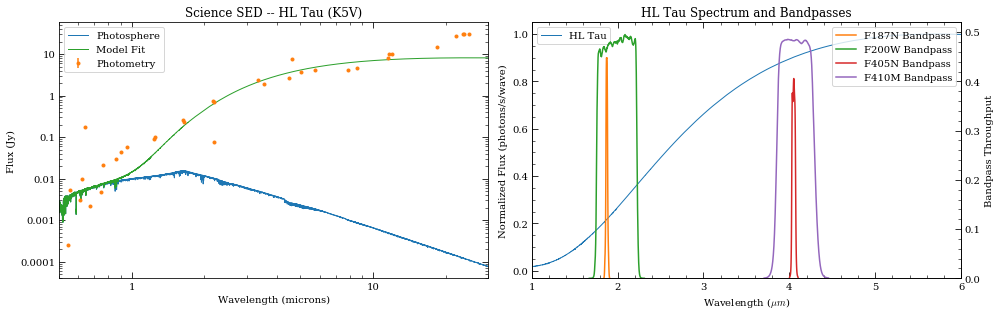

In [10]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot spectra 
fig, axes = plt.subplots(1,2, figsize=(14,4.5))

ax = axes[0]
src.plot_SED(ax=axes[0], xr=[0.5,30])
ax.set_title('Science SED -- {} ({})'.format(name_sci, spt_sci))
# ax.set_xscale('linear')
# ax.xaxis.set_minor_locator(AutoMinorLocator())


ax = axes[1]
xr = [1,6]

bp = pynrc.read_filter(*args_filter[-1])
sp = sp_sci
w = sp.wave / 1e4
o = S.Observation(sp, bp, binset=bp.wave)
sp.convert('photlam')
f = sp.flux / sp.flux[(w>xr[0]) & (w<xr[1])].max()

ind = (w>=xr[0]) & (w<=xr[1])
ax.plot(w[ind], f[ind], lw=1, label=sp.name)
ax.set_ylabel('Normalized Flux (photons/s/wave)')
sp.convert('flam')

ax.set_xlim(xr)
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('{} Spectrum and Bandpasses'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+1], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_SED.pdf'.format(name_sci.replace(' ','')))


### Generate observations

(-1, 1)

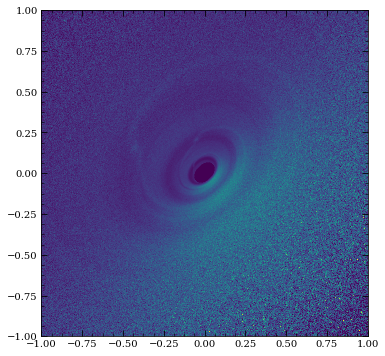

In [11]:
from astropy.io import fits
from astropy.modeling.models import Ellipse2D

hdul = fits.open(outdir + 'model_HLTau.fits')

# Data is in million Jy per Steradian
data = hdul[0].data
data_wave = 1.6 # micons
pa_offset = 315

# Arcsec/pixel
pix_asec = 0.0031

# Steradians to square arcsec
sr_to_asec2 = (3600*180/np.pi)**2

# Data in Jy/arcsec^2
data *= (1e9 * pix_asec**2 / sr_to_asec2) # mJy / pixel

# Mask inner disk region
r_pix, th_ang = nrc_utils.dist_image(data, return_theta=True)
x_pix, y_pix = nrc_utils.rtheta_to_xy(r_pix, th_ang)
aval = int(0.075 / pix_asec)
bval = int(aval * 0.707)
el = Ellipse2D(theta=0, a=aval, b=bval)
el_im = el(x_pix,y_pix)

rho, th = nrc_utils.dist_image(data, pixscale=pix_asec, return_theta=True)
data[el_im==1] = 0

hdul[0].data = nrc_utils.rotate_offset(data, pa_offset, reshape=False)

args_disk = (hdul, pix_asec, dist_sci, data_wave, 'mJy/pixel')
#hdul_out = pynrc.obs_nircam.model_to_hdulist(args_disk, sp_sci, bp)

x_new, y_new = nrc_utils.xy_rot(x_pix, y_pix, pa_offset)
r_new, th_new = nrc_utils.xy_to_rtheta(x_new, y_new/0.707)
rho_new = rho.max() * r_new / r_new.max()

extent = np.array([-1,1,-1,1]) * hdul[0].data.shape[0] * pix_asec / 2
im = hdul[0].data * rho_new**2
plt.imshow(im, extent=extent, vmin=0, vmax=im[rho<1].max())

xy = np.array([-1,1])
plt.xlim(xy)
plt.ylim(xy)


In [12]:
subsize = 160

# Create a dictionary that holds the obs_hci class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, args_disk=args_disk, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)


F187N_none_none
F200W_none_none
F405N_none_none
F410M_none_none


In [13]:
# Update detector readout
for i, key in enumerate(filt_keys):
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',10,480,480)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')

### Saturation 

In [14]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec


F187N_none_none
Sci: HL Tau
  0 saturated pixel at NGROUP=2; Max Well: 0.44
  5 saturated pixel at NGROUP=10; Max Well: 2.19
  Sat Dist NG=2: 0.00 arcsec
Ref: HL Tau
  0 saturated pixel at NGROUP=2; Max Well: 0.44
  5 saturated pixel at NGROUP=10; Max Well: 2.19

F200W_none_none
Sci: HL Tau
  13 saturated pixel at NGROUP=2; Max Well: 10.20
  66 saturated pixel at NGROUP=10; Max Well: 50.99
  Sat Dist NG=2: 0.08 arcsec
Ref: HL Tau
  11 saturated pixel at NGROUP=2; Max Well: 10.17
  62 saturated pixel at NGROUP=10; Max Well: 50.87

F405N_none_none
Sci: HL Tau
  9 saturated pixel at NGROUP=2; Max Well: 4.04
  21 saturated pixel at NGROUP=10; Max Well: 20.19
  Sat Dist NG=2: 0.13 arcsec
Ref: HL Tau
  9 saturated pixel at NGROUP=2; Max Well: 3.98
  15 saturated pixel at NGROUP=10; Max Well: 19.92

F410M_none_none
Sci: HL Tau
  59 saturated pixel at NGROUP=2; Max Well: 48.64
  171 saturated pixel at NGROUP=10; Max Well: 243.21
  Sat Dist NG=2: 0.32 arcsec
Ref: HL Tau
  51 saturated pixel at

### Roll Subtraction Curves

In [15]:
# Determine contrast curves for various WFE drift values
wfe_list = [0, 1, 2, 5]

nsig = 5
roll = 10

# fk_contrast = ['F444W_none_none', 'F410M_none_none']
curves_dict = do_contrast(obs_dict, wfe_list, filt_keys,
                          nsig=nsig, roll_angle=roll, opt_diff=False, no_ref=True)

F187N_none_none
F200W_none_none
F405N_none_none
F410M_none_none


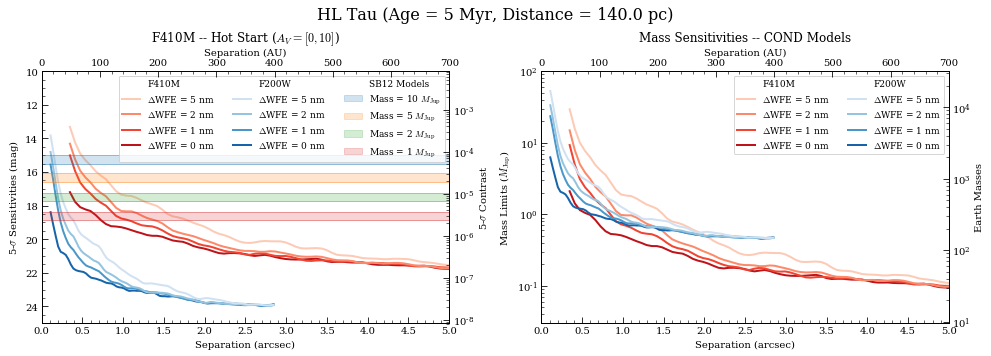

In [18]:
lin_vals = np.linspace(0.2,0.8,len(wfe_list))
c1 = plt.cm.Reds_r(lin_vals)
c2 = plt.cm.Blues_r(lin_vals)

key1, key2 = ('F410M_none_none', 'F200W_none_none') #filt_keys[-2:][::-1]
lab1 = '{}'.format(obs_dict[key1].filter)
lab2 = '' if key2 is None else '{}'.format(obs_dict[key2].filter)
fig, axes_all = do_plot_contrasts2(key1, key2, curves_dict, nsig, obs_dict, wfe_list, age_sci,
                                   sat_dict=sat_dict, label1=lab1, label2=lab2, c1=c1, c2=c2, 
                                   xr=[0,5], yr=[25,10], yscale2='log', yr2=[3e-2, 100])


fig.subplots_adjust(top=0.8, bottom=0.1 , left=0.05, right=0.95)
fname = "{}_contrast.pdf".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)

### Images

In [20]:
# Planet b:
#   L = 4.8 + 12.5 = 17.3
#   M = 4.8 + 11.8 = 16.6

# Add known planets
dL_arr  = np.array([-1,-1,-1]) # L-Band mag contrast
Lbp     = pynrc.read_filter('F360M') # Approx L-Band
rth_arr = [(0.2,0),(0.5,0),(0.8,0)] # sep (asec), PA
for key in filt_keys:
    obs = obs_dict[key]
    obs.kill_planets()
    
    Kobs = S.Observation(obs.sp_sci, bp_k, binset=bp_k.wave)  
    Lobs = S.Observation(obs.sp_sci, Lbp, binset=Lbp.wave)    
    Lmag_arr = Lobs.effstim('vegamag') + dL_arr
#     print(Kobs.effstim('vegamag'), Lobs.effstim('vegamag'))
#     print(Lobs.effstim('vegamag'), Lmag_arr)
    
    mass_arr = [10,5,5]
    mdot_arr = [0,0,0]
    av_arr   = [2,2,2]
    for i, Lmag in enumerate(Lmag_arr):
        renorm_args=(Lmag,'vegamag',Lbp) if dL_arr[i]>=0 else None
        accr = True if mdot_arr[i]>0 else False
        obs.add_planet(rtheta=rth_arr[i], runits='asec', age=age_sci, mass=mass_arr[i], entropy=13, 
                       accr=accr, mdot=mdot_arr[i], Av=av_arr[i], renorm_args=renorm_args)

        
    pl_mags = []
    for pl in obs.planets:
        sp = obs.planet_spec(**pl)
        renorm_args = pl['renorm_args']
        sp_norm = sp.renorm(*renorm_args) if renorm_args is not None else sp
        sp_norm.name = sp.name
        sp = sp_norm

        o = S.Observation(sp, obs.bandpass, binset=obs.bandpass.wave)
        pl_mags.append(o.effstim('vegamag'))
        
    print('Planet Mags:', key, pl_mags)
  

Planet Mags: F187N_none_none [16.72721158858222, 19.1002480600736, 19.1002480600736]
Planet Mags: F200W_none_none [16.357487478133553, 18.207931546362268, 18.207931546362268]
Planet Mags: F405N_none_none [15.10291652682238, 16.1724100985425, 16.1724100985425]
Planet Mags: F410M_none_none [15.119177307671968, 16.175222122808396, 16.175222122808396]


In [21]:
# Ideal
wfe_ref = 0
wfe_roll = 0
hdul_dict_ideal = do_gen_hdus(obs_dict, filt_keys, wfe_ref, wfe_roll, no_ref=False, opt_diff=False,
                              oversample=4, PA1=0, PA2=0, exclude_noise=True)


F187N_none_none
F200W_none_none
F405N_none_none
F410M_none_none


In [22]:
# Roll Subtracted
wfe_ref = 0
wfe_roll = 1
hdul_dict = do_gen_hdus(obs_dict, filt_keys, wfe_ref, wfe_roll, no_ref=True, opt_diff=False,
                        oversample=4, PA1=-5, PA2=5)

F187N_none_none
F200W_none_none
F405N_none_none
F410M_none_none


In [23]:
fk_images = [
    'F187N_none_none',
    'F200W_none_none',
    'F405N_none_none',
    'F410M_none_none',
]

fk_images = filt_keys

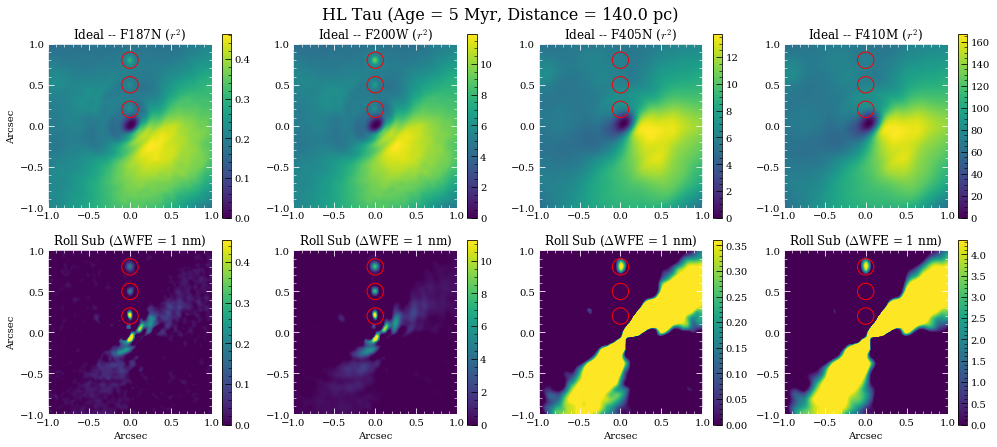

In [24]:
from copy import deepcopy
fig, axes_arr = plt.subplots(2,4, figsize=(14,6.3))

xylim = 1
xr = yr = np.array([-1,1])*xylim

axes = axes_arr[0]
for i, k in enumerate(fk_images):
    ax = axes[i]
    hdul = deepcopy(hdul_dict_ideal[k])
    pixscale=hdul[0].header['PIXELSCL']

    # Mask out inner region
    mask_rad = 0.1
    rho = nrc_utils.dist_image(hdul[0].data, pixscale=pixscale)
#     hdul[0].data[rho<=mask_rad] = 0
    
    r_pix, th_ang = nrc_utils.dist_image(hdul[0].data, return_theta=True)
    x_pix, y_pix = nrc_utils.rtheta_to_xy(r_pix, th_ang)
    x_new, y_new = nrc_utils.xy_rot(x_pix, y_pix, 315)
    r_new, th_new = nrc_utils.xy_to_rtheta(x_new, y_new/0.707)
    rho_new = rho.max() * r_new / r_new.max()
    hdul[0].data = hdul[0].data * rho_new**2
    
    vmax = np.nanmax(hdul[0].data[(rho>mask_rad) & (rho<xylim)])
    plot_hdulist(hdul, ax=ax, xr=xr, yr=yr, vmax=vmax, cb_label='', interpolation='sinc')
    ax.set_title('Ideal -- {} ($r^2$)'.format(obs_dict[k].filter))
    


axes = axes_arr[1]
for i, k in enumerate(fk_images):
    ax = axes[i]
    hdul = deepcopy(hdul_dict[k])
    pixscale=hdul[0].header['PIXELSCL']
    
    # Saturation radius
    sat_rad = sat_dict[k]
    
    # Mask out inner region
    mask_rad = np.max([sat_rad, 0])

    # Mask inner disk region
    r_pix, th_ang = nrc_utils.dist_image(hdul[0].data, return_theta=True)
    x_pix, y_pix = nrc_utils.rtheta_to_xy(r_pix, th_ang)
    bval = int(sat_rad / pixscale)
    aval = int(bval * 1.41)
    el = Ellipse2D(theta=315, a=aval, b=bval)
    el_im = el(x_pix,y_pix)
    #hdul[0].data[el_im>0] = 0

    rho,th = nrc_utils.dist_image(hdul[0].data, pixscale=pixscale, return_theta=True)

    vmax = np.nanmax(hdul[0].data[(rho>mask_rad) & (rho<xylim)])
    #hdul[0].data[rho<=mask_rad] = 0
    vmax = np.nanmax(hdul[0].data[(rho>0.2) & (rho<1) & (th<10) & (th>-10)])
    
    plot_hdulist(hdul, ax=ax, xr=xr, yr=yr, vmin=0, vmax=vmax, cb_label='', interpolation='sinc')
    ax.set_title('Roll Sub (' + '$\Delta$' + 'WFE = {} nm)'.format(wfe_roll))
    

# Location of planet
for pl in obs.planets:
    loc = (np.array(pl['xyoff_pix'])) * obs.pix_scale
    for ax in axes_arr.flatten():
        circle = matplotlib.patches.Circle(loc, radius=xylim/10., lw=1, edgecolor='red', facecolor='none')
        ax.add_artist(circle);
        
for axes in axes_arr:
    for i, ax in enumerate(axes):
        if i>0: ax.set_ylabel('')
for ax in axes_arr[0]:
    ax.set_xlabel('')
            

# Title
dist = obs.distance
age_str = 'Age = {:.0f} Myr'.format(age_sci)
dist_str = 'Distance = {:.1f} pc'.format(dist)
title_str = '{} ({}, {})'.format(name_sci,age_str,dist_str)

fig.suptitle(title_str, fontsize=16);

fig.tight_layout()
fig.subplots_adjust(top=0.92)

fname = "{}_images.pdf".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)